In [ ]:
!pip install yfinance
!pip install pandas-ta

In [14]:
import pandas as pd
import numpy as np
import pandas_ta as pd_ta
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import date
import warnings
from pprint import pprint 
import random
warnings.filterwarnings('ignore')

In [9]:
# global settings 
timeframe: str = '1d'

In [54]:
# import all stock tickers in the SPY500
table = pd.read_csv("/content/SPX_Tickers.txt")
tickers = table['Symbol'].to_list()
get_index = random.randrange(len(tickers))
#tickers = random.sample(tickers, 500)

In [55]:
def fetch_data(ticker: str, timeframe: str): 
  """fetch data from yf"""

  # download stock data from yfinance
  if 'd' in timeframe.lower(): 
    start = '2004-01-01'
  elif 'm' in timeframe.lower(): 
    start = '2022-10-01'
  else: 
    start = '2022-09-01'
  end = str(date.today())
  df = yf.Ticker(ticker).history(interval=timeframe, start=start, end=end)
  
  # preprocess dataframe
  try: 
    df.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
  except KeyError: 
    pass
  return df

def create_channel(df, period=30, sma_period=150): 
  """create high low channel"""

  # compute high and low channels
  df['High_CH'] = pd_ta.sma(df['High'], length=period)
  df['Low_CH'] = pd_ta.sma(df['Low'], length=period)
  df['SMA150'] = pd_ta.sma(df['Close'], length=sma_period)

  # remove nans
  df.dropna(inplace=True)
  return df

def identify_setup(df, retrieve_history: int = 100): 
  """find potential setups by looking at breakouts and crossovers in the high-low channel"""
  
  # create a subset of the dataframe
  sub_df = df.iloc[-retrieve_history:][['Close', 'High_CH', 'Low_CH', 'SMA150']]

  # categorize the uptrend, downtrend, and pullback price actions
  sub_df['UPTREND'] = sub_df['Close'] > sub_df['High_CH']
  sub_df['UPTREND'] = sub_df['UPTREND'].apply(lambda x: 1 if x else 0)
  sub_df['DOWNTREND'] = sub_df['Close'] < sub_df['Low_CH']
  sub_df['DOWNTREND'] = sub_df['DOWNTREND'].apply(lambda x: 1 if x else 0)
  sub_df['PULLBACK'] = (sub_df['Low_CH'] < sub_df['Close']) & (sub_df['Close'] < sub_df['High_CH'])
  sub_df['PULLBACK'] = sub_df['PULLBACK'].apply(lambda x: 1 if x else 0)
  if sub_df['PULLBACK'].iloc[-2] and not sub_df['PULLBACK'].iloc[-1]: 
    return True
  else: 
    return False

True


Text(0.5, 1.0, 'PPBT')

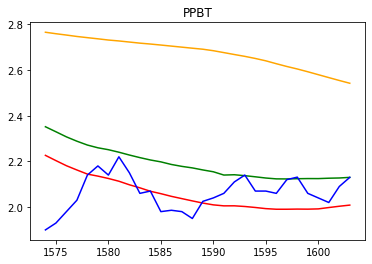

In [56]:
ticker: str = "PPBT"
df = fetch_data(ticker, '1d')
df = create_channel(df, period=30)
df.reset_index(inplace=True)
print(identify_setup(df))

history = 30
plt.plot(df['High_CH'][-history:], color='green')
plt.plot(df['Low_CH'][-history:], color='red')
plt.plot(df['Close'][-history:], color='blue')
plt.plot(df['SMA150'][-history:], color='orange')
plt.title(f"{ticker}")

In [57]:
viable_tickers: list = []
for ticker in tqdm(tickers): 
  try: 
    df = fetch_data(str(ticker), '1d')
    df = create_channel(df, period=30)
    df.reset_index(inplace=True)
    check = identify_setup(df)
    if check: 
      viable_tickers.append(ticker)
  except IndexError: 
    continue

 94%|█████████▎| 473/505 [04:13<00:13,  2.38it/s]

Got error from yahoo api for ticker VIAC, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- VIAC: No data found for this date range, symbol may be delisted


 98%|█████████▊| 494/505 [04:26<00:06,  1.61it/s]

Got error from yahoo api for ticker WLTW, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- WLTW: No data found for this date range, symbol may be delisted


 99%|█████████▉| 499/505 [04:29<00:03,  2.00it/s]

Got error from yahoo api for ticker XLNX, Error: {'code': 'Not Found', 'description': 'No data found, symbol may be delisted'}
- XLNX: No data found for this date range, symbol may be delisted


100%|██████████| 505/505 [04:31<00:00,  1.86it/s]


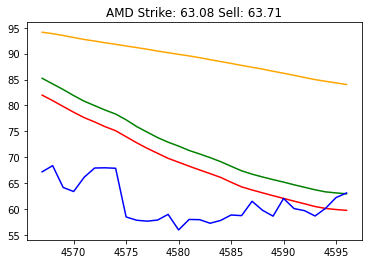

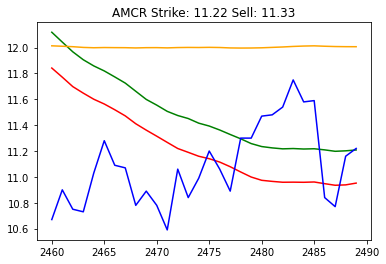

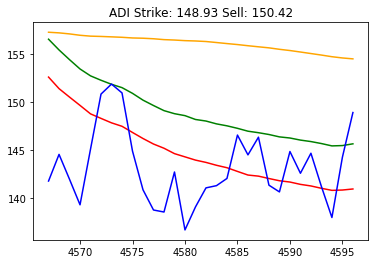

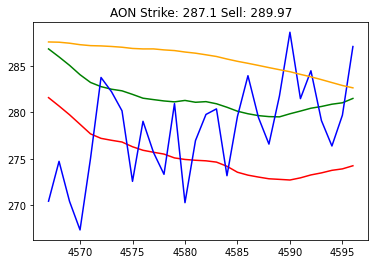

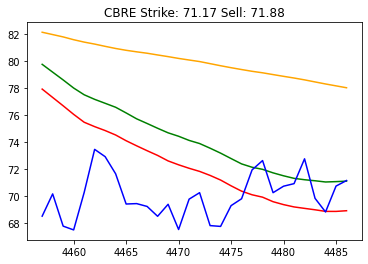

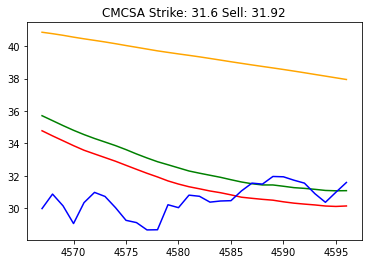

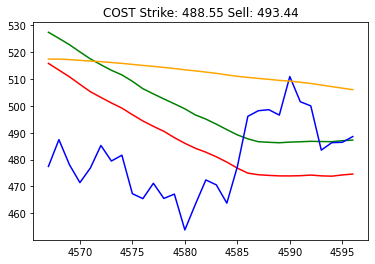

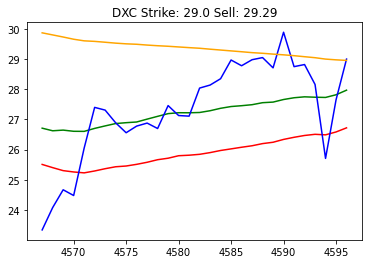

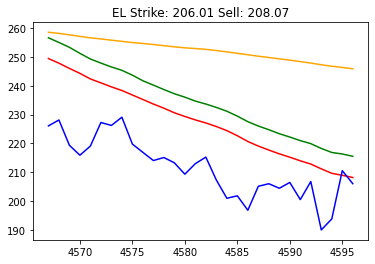

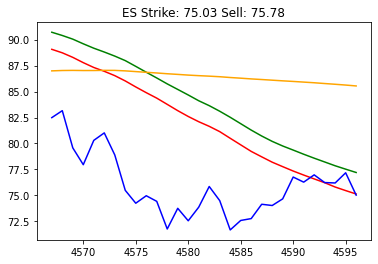

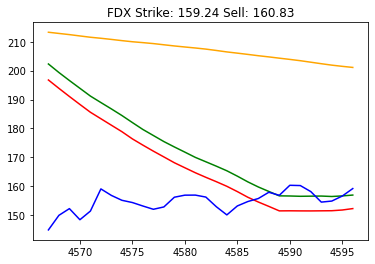

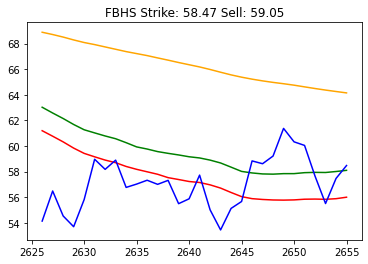

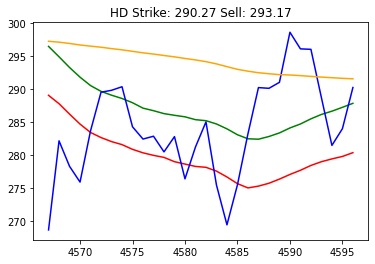

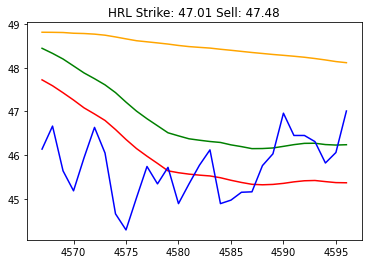

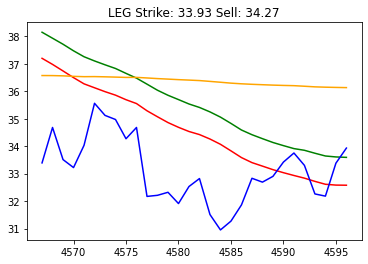

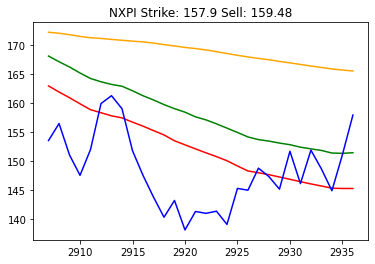

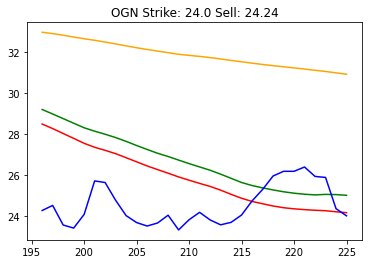

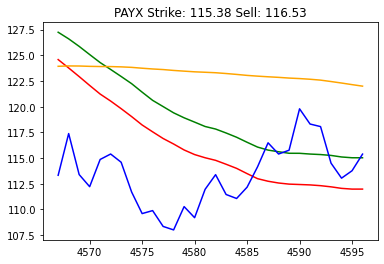

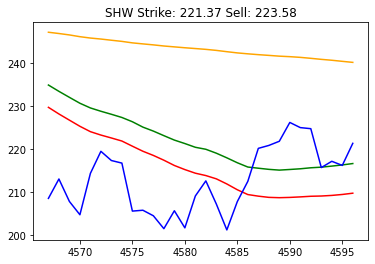

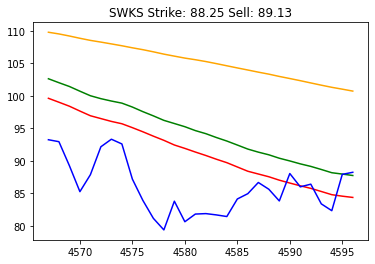

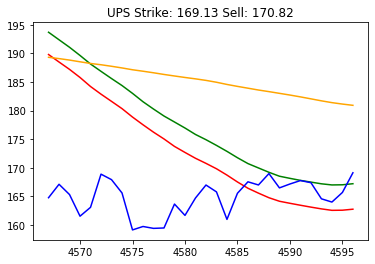

In [58]:
for ticker in viable_tickers: 
  df = fetch_data(str(ticker), '1d')
  df = create_channel(df, period=30)
  df.reset_index(inplace=True)
  history = 30
  plt.plot(df['High_CH'][-history:], color='green')
  plt.plot(df['Low_CH'][-history:], color='red')
  plt.plot(df['Close'][-history:], color='blue')
  plt.plot(df['SMA150'][-history:], color='orange')
  plt.title(f"{ticker} Strike: {round(df['Close'].iloc[-1], 2)} Sell: {round(1.01*df['Close'].iloc[-1], 2)}")
  plt.show()